In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style('ticks')

In [220]:
def preprocess_race():

    race_df = pd.read_csv('../input/big-data-derby-2022/nyra_race_table.csv')

    race_df['race_id'] = race_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)
    race_df.insert(0, 'race_id', race_df.pop('race_id'))
    
    
    race_df['distance_feet'] = race_df['distance_id'].apply(lambda x : int(6.6 * x)) # to_feet
    
    race_df['race_date'] = pd.to_datetime(race_df['race_date'])
    
    race_df['track_condition'] = race_df['track_condition'].str.replace(" ", "")

    # Dirt Condition Separate 
    race_df.loc[race_df['course_type'] == 'D', 'dirt_condition'] = race_df['track_condition']
    dirt_condition_order = pd.CategoricalDtype(['FT', 'GD', 'MY', 'SY'], ordered = True)
    race_df['dirt_condition'] = race_df['dirt_condition'].astype(dirt_condition_order)
    
    # Turf Condition Separate
    race_df.loc[race_df['course_type'].isin(['I', 'O', 'T']), 'turf_condition'] = race_df['track_condition']
    turf_condition_order = pd.CategoricalDtype(['FM', 'GD', 'YL', 'SF'], ordered = True)
    race_df['turf_condition'] = race_df['turf_condition'].astype(turf_condition_order)
    
    race_df.drop(['purse', 'post_time', 'track_condition'], axis = 1, inplace = True)
    
    # drop hurdle race
    race_df.drop(race_df[race_df['course_type'] == 'M'].index, inplace = True)
    
    return race_df

def preprocess_start():
    start_df = pd.read_csv('../input/big-data-derby-2022/nyra_start_table.csv', 
                        names = ['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
    
    start_df['race_date'] = pd.to_datetime(start_df['race_date'])
    
    start_df['program_number'] = start_df['program_number'].str.replace(" ", "")
    return start_df

def preprocess_track():
    track_df = pd.read_csv('../input/big-data-derby-2022/nyra_tracking_table.csv')
    
    track_df['race_date'] = pd.to_datetime(track_df['race_date'])
    
    track_df['program_number'] = track_df['program_number'].str.replace(" ", "")

    return track_df

# 나중에 다른 파일에 전처리 과정을 또 넣을 수도 있기 때문에 위 과정은 함수로 따로 빼겠음
# 캐글에서만 사용 가능, 다른 곳에 쓸 경우 경로명 정도만 바꾸면 될 것임

def preprocess_2022_derby():
    race_df = preprocess_race()
    start_df = preprocess_start()
    track_df = preprocess_track()
    return race_df, start_df, track_df

race_df, start_df, track_df = preprocess_2022_derby()

# 2. 데이터 탐색
- 중구난방식으로 하기 보다, 무엇을 할지 적어 두고 어떤 작업을 진행하자

## 1. 계절과 트랙
- 트랙 컨디션 [위키](https://en.wikipedia.org/wiki/Going_(horse_racing))
    - `Dirt` 
        - `FT : Fast` : 건조하고 균일하며 탄력 있는 표면
        - `GD : Good` : `FT`보다는 느린 듯
        - `MY : Muddy` : 젖었음, 고인 물은 없음
        - `SY : Sloppy` : 고인 물이 보일 정도로 물로 포화된 트랙
    - `Turf`
        - `FM : Firm` : 단단하고 탄력 있는 표면
        - `GD : Good` : `FM`보다 약간 부드러운 잔디 코스
        - `YL : Yielding` : 최근 비가 와서 지면에 상당한 양의 `give(탄성)`가 있음
        - `SF : Soft` : 수분이 많음. 말이 깊게 가라앉을 수 있음


In [221]:
# 1. 계절과 트랙의 상태
race_df['month'] = race_df['race_date'].dt.month

race_df.loc[race_df['month'].isin([3, 4, 5]), 'season'] = 'spring'
race_df.loc[race_df['month'].isin([6, 7, 8]), 'season'] = 'summer'
race_df.loc[race_df['month'].isin([9, 10, 11]), 'season'] = 'autumn'
race_df.loc[race_df['month'].isin([12, 1, 2]), 'season'] = 'winter'

season_order = pd.CategoricalDtype(['spring', 'summer', 'autumn', 'winter'],
                                        ordered = True)

race_df['season'] = race_df['season'].astype(season_order)

race_df

,race_id,track_id,race_date,race_number,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_1,AQU,2019-01-01,1,650,D,36,AOC,4290,MY,NaN,1,winter
1,AQU_2019-01-01_2,AQU,2019-01-01,2,600,D,48,MCL,3960,MY,NaN,1,winter
2,AQU_2019-01-01_3,AQU,2019-01-01,3,550,D,54,MCL,3630,MY,NaN,1,winter
3,AQU_2019-01-01_4,AQU,2019-01-01,4,900,D,101,AOC,5940,MY,NaN,1,winter
4,AQU_2019-01-01_5,AQU,2019-01-01,5,700,D,60,ALW,4620,MY,NaN,1,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,SAR_2019-09-02_7,SAR,2019-09-02,7,900,D,79,CLM,5940,SY,NaN,9,autumn
1996,SAR_2019-09-02_8,SAR,2019-09-02,8,700,D,32,AOC,4620,SY,NaN,9,autumn
1997,SAR_2019-09-02_9,SAR,2019-09-02,9,850,I,22,STK,5610,NaN,SF,9,autumn
1998,SAR_2019-09-02_10,SAR,2019-09-02,10,700,D,32,STK,4620,SY,NaN,9,autumn


In [222]:
sub_dirt_df = (race_df.groupby(['season', 'dirt_condition'])['race_id'].count()
                                                                      .to_frame()
                                                                      .reset_index()
                                                                      .rename(columns = {"race_id" : 'counts'})
              )
sub_dirt_df = sub_dirt_df[sub_dirt_df['counts'] != 0]

sub_turf_df = (race_df.groupby(['season', 'turf_condition'])['race_id'].count()
                                                                       .to_frame()
                                                                       .reset_index()
                                                                       .rename(columns = {"race_id" : 'counts'})
              )
sub_turf_df = sub_turf_df[sub_turf_df['counts'] != 0]

- 색은 여기서 뽑아옴 : [color-hex.com](https://www.color-hex.com/)
- seaborn의 기능을 이용해도 되긴 함

In [223]:
dirt_colors = ['#783f04', '#bb8632', '#cca466', '#ddc299']
turf_colors = ['#38761d', '#5f914a', '#87ac77', '#afc8a4']

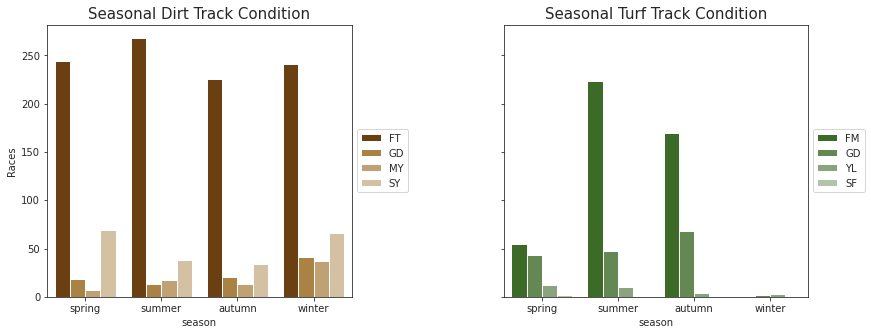

In [224]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)

dirt_palette = sns.set_palette(sns.color_palette(dirt_colors))
sns.barplot(data = sub_dirt_df,
              x = 'season',
              y = 'counts',
             hue = 'dirt_condition',
             ax = ax[0],
             palette = dirt_palette
           )
ax[0].set_title('Seasonal Dirt Track Condition')
ax[0].set_ylabel('Races')
ax[0].legend().set_visible(False)
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))


turf_palette = sns.set_palette(sns.color_palette(turf_colors))
sns.barplot(data = sub_turf_df,
              x = 'season',
              y = 'counts',
             hue = 'turf_condition',
             ax = ax[1],
           palette = turf_palette
           )

ax[1].set_title('Seasonal Turf Track Condition')
ax[1].set_ylabel(None)

# legend
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax[1].legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

- 봄과 겨울에 `SY`의 빈도가 높아짐
- 비슷하게 `Turf`도 여름, 가을의 컨디션이 좋으며 겨울에는 거의 진행되지 않음(잔디라 그런 듯)
- `Dirt`의 경기 수가 전반적으로 많은 걸 볼 수 있음

- 참고) 같은 날, 같은 경기장, 같은 트랙이더라도 경기장 상태(`track_condition`은 다를 수 있다)
    - 예를 들면 비가 와서 `SY`였다가 날이 맑아서 시간이 갈수록 `MY`로 바뀔 수도 있음
    - 경기마다 `track_condition`이 따로 있는 이유이기도 하다

## 2. 기수

In [225]:
merged_df = start_df.merge(race_df,
                on = ['track_id', 'race_date', 'race_number'])
merged_df.insert(0, 'race_id', merged_df.pop('race_id'))
merged_df.head(2)

,race_id,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_1,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,D,36,AOC,4290,MY,NaN,1,winter
1,AQU_2019-01-01_1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,D,36,AOC,4290,MY,NaN,1,winter


### 1. 기수와 출전한 경기 수, 평균 순위, 코스 타입 당 평균 순위
- `Turf`, `Outer turf`, `Inner turf` 자체는 유지하겠음

In [281]:
jockey_df = merged_df.loc[:, ['race_id', 'jockey', 'course_type', 'dirt_condition', 'turf_condition', 'position_at_finish']]
jockey_df[['dirt_condition', 'turf_condition']].fillna(0)
jockey_df

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

상관계수 : -0.631658005069876, p-value : 1.0554257650012832e-07


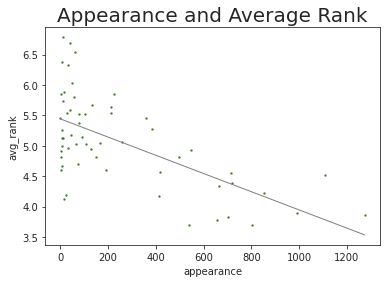

In [227]:
# 1. 출전 수와 평균 순위
jockey_df['appearance'] = jockey_df.groupby('jockey')['race_id'].transform('nunique')
jockey_df.head(3)

app_rank = (jockey_df.groupby('appearance')['position_at_finish']
                                                                .mean()
                                                                .to_frame()
                                                                .reset_index()
                                                                .rename(columns = {'position_at_finish' : 'avg_rank'})
           )

sns.regplot(data = app_rank,
            x = 'appearance',
            y = 'avg_rank',
            ci = None,
            line_kws = {'color' : 'grey',
                        'lw' : 1},
            scatter_kws = {'s' : 2})
plt.title("Appearance and Average Rank", fontsize = 20)

corrcoef, p_value = stats.pearsonr(x = app_rank['appearance'],
                                   y = app_rank['avg_rank'])
print(f"상관계수 : {corrcoef}, p-value : {p_value}")

### 운동하고 저녁에 여기 좀 본다
- 한 줄에 `turf_appearance`와 `dirt_appearance`를 동시에 넣는 법
    - `groupby.count`는 NaN 값을 세지 못한다!
    - 별도의 테이블을 만들고 진행하는 방법을 일단 구현해보고, 다른 방법이 있을까 생각해본다
    - `unstack(fill_value = 0).stack()`을 이용할 수 있긴 한데, 이건 계위가 있는 데이터프레임에만 적용가능한 것 같다.

In [323]:
# 2. Dirt, Turf 별 Appearance와 평균 순위
jockey_df.head(2)

,race_id,jockey,course_type,dirt_condition,turf_condition,position_at_finish,appearance,dirt_appearance,turf_appearance
0,AQU_2019-01-01_1,Dylan Davis,D,MY,NaN,2,1108,759.0,NaN
1,AQU_2019-01-01_1,Junior Alvarado,D,MY,NaN,3,852,547.0,NaN


#### 2. 상위 경기수 10명의 기수에 대해, 각 트랙에서의 평균 순위

In [231]:
top_10_df = jockey_df[jockey_df['jockey'].isin(top_10_appear_jockey)][:]
top_10_track_rank_df = top_10_df.groupby(['jockey', 'course_type', 'track_condition'])['position_at_finish'].agg(['mean', 'count'])\
                                                                                                            .dropna()

KeyError: 'track_condition'

In [ ]:
top_10_track_rank_df.reset_index(inplace = True)

In [ ]:
top_10_track_rank_df

In [ ]:
fig, ax = plt.subplots(10, 2, 
                       figsize = (20, 50), 
#                        constrained_layout = True
                      )
plt.subplots_adjust(hspace = 0.3)
parameters = {'figure.titlesize' : 20,
             'axes.titlesize' : 15}
plt.rcParams.update(parameters)

for i in range(10):
    sns.barplot(
                data = top_10_track_rank_df[top_10_track_rank_df['jockey'] == top_10_appear_jockey[i]][:],
                x = 'course_type',
                y = 'mean',
                hue = 'track_condition',
                ax = ax[i][0]
               )

    ax[i][0].set_title(f'About {top_10_appear_jockey[i]} rank')
    ax[i][0].set_ylabel('average rank')
    ax[i][0].set_ylim([0, 10])
    ax[i][0].legend().set_visible(False)
#     ax[i][0].bar_label(ax[i][0].containers[0])

    sns.barplot(
                data = top_10_track_rank_df[top_10_track_rank_df['jockey'] == top_10_appear_jockey[i]][:],
                x = 'course_type',
                y = 'count',
                hue = 'track_condition',
                ax = ax[i][1]
               )

    ax[i][1].set_title(f'{top_10_appear_jockey[i]} : Number Of Matches')
    ax[i][1].set_ylabel('Matches')
    ax[i][1].legend(loc = 'upper right')
    ax[i][1].set_ylim([0, 650])
#     ax[i][1].bar_label(ax[i][1].containers[0])


- **꼭 분석해야 할 경기** : **`Dirt - FT`, `Turf - FM`** (빈도가 잦기 때문)
    - `Dirt - SY`도 생각보다 잦다.

In [ ]:
temp_df = race_df.groupby(['course_type', 'track_condition'])['race_id'].count().to_frame().reset_index()

In [ ]:
sns.barplot(data = temp_df,
           x = 'course_type',
           y = 'race_id',
           hue = 'track_condition')

### 3. Turf의 종류(Inner, Outer, Turf) 간 유의미한 차이가 있는가?
- 물론 달리는 위치가 다를 것이므로 전체적인 구분은 의미가 있을 것임 : 회전 반경이 넓냐 좁냐도 경주에 영향을 미칠 것이기 때문임

In [ ]:
turf_race_df = race_df[race_df['course_type'].isin(['O', 'T', 'I'])][:]
turf_race_df.head(2)

In [ ]:
turf_race_df[['track_id', 'course_type']]

### 경기장 보기
- [참고](https://www.kaggle.com/code/iamleonie/big-data-derby-step-by-step-analysis#Missing-Data) 
    - 경,위도 데이터를 보고 경기장을 그릴 수 있다는 생각은 못했다. 아이디어만 보고 구현은 직접 해본다

In [ ]:
track = start_df['track_id'].unique()
total_df = race_df.merge(track_df, on = ['track_id', 'race_date', 'race_number'])

In [ ]:
track_lst = race_df['track_id'].unique()
track_lst

In [ ]:
race_df['course_type'].unique()

In [ ]:
# 경기장을 나타내는 점들이기 때문에 사실 하려는 거에 비해 점이 너무 많긴 함
# 이를 줄여줘도 됨


fig, ax = plt.subplots(3, 1, figsize = (15, 45))
track_palette = {'D' : '#744700',
        'T' : '#38761d',
        'I' : '#91cd76',
        'O' : '#91cd76', 
        'M' : '#d9ead3'}

for i, v in enumerate(track_lst):
    temp_df = total_df[total_df['track_id'] == v][['course_type', 'latitude', 'longitude']]

    sns.scatterplot(data = temp_df,
                       x = 'latitude',
                       y = 'longitude',
                       hue = 'course_type',
                        ax = ax[i],
                   palette = track_palette)
    
    ax[i].set_title(f'Track : {v}')

- trakus가 뭔지 (나중에) 보자

In [ ]:
list(test.groups.keys())